In [1]:
# Global imports
import sys, os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import Counter, OrderedDict

%matplotlib inline 
#%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.style.use(['dark_background'])

import numpy as np
import json
import collections
from scipy import stats
import random
import math
from datetime import datetime

# Local import
sys.path.insert(0, '../training/methods/')
# Import the neural network architectures:
from MLP import Net as MLP
from CNN import Net as CNN

sys.path.insert(0, '../training/src/')
from dataset import merger_dataset, splitDataLoader, ToTensor, Normalize

# User-defined parameters

In [44]:
working_dir = "/home/mquesnel/Courses/DeepLearning/"
path_to_models = working_dir+'models/'
path_to_datasets = working_dir+"/datasets/density_transformed/"

dl_arch = 'cnn'
nb_layer = 2
train_val_dataset_size = 1280
output_dim = 2
optimizer_name =  "Adam" 
batch_size = 32 
learning_rate = '1e-4' 
nb_epoch = 50
metric = 'rmse'
split_train = '90'

test_dataset_size = 105

# Display the training and validation losses

## Read the train/val losses

In [45]:
if dl_arch == 'mlp':
    layer_str = '_2hl_'
elif dl_arch == 'cnn':
    layer_str = '_3cv_'
else:
    raise ValueError("the model name specified is not valid")

model_name = 'model_'+str(train_val_dataset_size)+'cubes_'+str(output_dim)+'targ_'+dl_arch+layer_str+'bs'+str(batch_size)+\
'_lr'+str(learning_rate)+'_'+str(nb_epoch)+'ep_opt'+str(optimizer_name)+'_split'+split_train+'_'+metric+'_relu1'#_batchnorm'

metrics_file = path_to_models+model_name+'/metrics.json'

with open(metrics_file) as json_file:
    data = json.load(json_file)

## Plot the losses

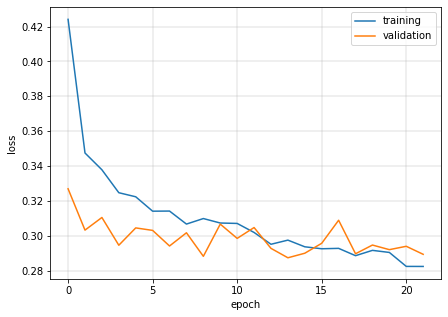

In [46]:
fig = plt.figure(1, figsize=(7,5))
plt.plot(data['train_loss'], label='training')
plt.plot(data['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.grid(linewidth=0.4)

In [41]:
print(np.min(data['train_loss']))
print(np.min(data['val_loss']))

0.28851447047458756
0.2873116283435521


# Load the model

In [6]:
# Load model architecture:
if dl_arch == 'mlp':
    model = MLP(70**3, output_dim).eval()
    layer_str = '_2hl_'
elif dl_arch == 'cnn':
    model = CNN(1, output_dim).eval()
    layer_str = '_3cv_'
else:
    raise ValueError("the model name specified is not valid")

model_file = path_to_models+model_name+'/model.pth'

assert os.path.isfile(model_file), "{} does not exist".format(model_file)
print("Model file name: {}\n".format(model_file))

state_dict = torch.load(model_file, map_location='cpu')

new_state_dict = OrderedDict()

model.load_state_dict(state_dict)

Model file name: /home/mquesnel/Courses/DeepLearning/models/model_1280cubes_2targ_cnn_3cv_bs32_lr1e-4_50ep_optAdam_split90_rmse_relu1_batchnorm/model.pth



<All keys matched successfully>

# Create the dataset object

We apply the same transformations to the test dataset than to the training/validation set

In [7]:
# Define name of the hdf5 file containing the test data:
test_file = path_to_datasets+"merger_test_"+str(test_dataset_size)+"cubes.h5"

assert os.path.isfile(test_file), "{} does not exist".format(test_file)
print("Test dataset filename: {}".format(test_file))  

transfo = transforms.Compose([Normalize(), ToTensor()])

# Create the dataset object:xc
test_dataset = merger_dataset(path_to_file = test_file, 
                          size = test_dataset_size,
                          transform = transfo)

Test dataset filename: /home/mquesnel/Courses/DeepLearning//datasets/density_transformed/merger_test_105cubes.h5


# Perform predictions

In [8]:
prediction_list = []
ratio_list = []
rmse_list = []
for id in range(test_dataset_size):
    
    sample = test_dataset[id]

    ratio = sample['target'].numpy()
    if output_dim == 1:
        ratio = ratio[0]
    density = sample['input'].unsqueeze(0)

    prediction = model(density).detach().numpy()[0]
    
    prediction_list.append(prediction)
    ratio_list.append(ratio)

In [9]:
print(ratio)

[0.40254238 0.7584746 ]


In [10]:
for i in range(test_dataset_size):
    print("id={}".format(i))
    print("prediction:")
    print(prediction_list[i])
    print("true ratio:")
    print(ratio_list[i])
    print()

id=0
prediction:
[0.25706977 0.30298504]
true ratio:
[0.15677966 0.11864407]

id=1
prediction:
[0.25847647 0.29688615]
true ratio:
[0.15677966 0.11864407]

id=2
prediction:
[0.28677914 0.32578376]
true ratio:
[0.15677966 0.11864407]

id=3
prediction:
[0.2680256  0.31107667]
true ratio:
[0.15677966 0.11864407]

id=4
prediction:
[0.30291477 0.3353772 ]
true ratio:
[0.15677966 0.11864407]

id=5
prediction:
[0.29581335 0.32877284]
true ratio:
[0.15677966 0.11864407]

id=6
prediction:
[0.23755062 0.29696152]
true ratio:
[0.15677966 0.11864407]

id=7
prediction:
[0.2539232 0.3053177]
true ratio:
[0.15677966 0.11864407]

id=8
prediction:
[0.2608549  0.31469086]
true ratio:
[0.15677966 0.11864407]

id=9
prediction:
[0.31677547 0.3594466 ]
true ratio:
[0.41525424 0.3220339 ]

id=10
prediction:
[0.25802523 0.30287907]
true ratio:
[0.41525424 0.3220339 ]

id=11
prediction:
[0.2519354 0.2928857]
true ratio:
[0.41525424 0.3220339 ]

id=12
prediction:
[0.27826437 0.32726872]
true ratio:
[0.41525424 

# Evaluation metrics

In [11]:
pred = np.array(prediction_list)
truth = np.array(ratio_list)

### Compute the MSE

In [12]:
mse = np.mean((pred - truth)**2)
print(mse)

0.13154799


### Compute the RMSE

In [13]:
rmse = np.sqrt(np.mean((pred - truth)**2))
print(rmse)

0.36269546


### Compute the MAE

In [14]:
mae = np.mean(np.abs(pred - truth))
print(mae)

0.29468697
